<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-used" data-toc-modified-id="Data-used-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data used</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Wards-data" data-toc-modified-id="Wards-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Wards data</a></span></li><li><span><a href="#Foursquare-data" data-toc-modified-id="Foursquare-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Foursquare data</a></span></li><li><span><a href="#Analysis-of-the-data-prepared" data-toc-modified-id="Analysis-of-the-data-prepared-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Analysis of the data prepared</a></span></li><li><span><a href="#Segment-wards-using-KMeans" data-toc-modified-id="Segment-wards-using-KMeans-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Segment wards using KMeans</a></span></li></ul></li><li><span><a href="#Clusters-description" data-toc-modified-id="Clusters-description-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clusters description</a></span><ul class="toc-item"><li><span><a href="#Cluster-0---red" data-toc-modified-id="Cluster-0---red-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Cluster 0 - red</a></span></li><li><span><a href="#Cluster-1---purple" data-toc-modified-id="Cluster-1---purple-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cluster 1 - purple</a></span></li><li><span><a href="#Cluster-2---blue" data-toc-modified-id="Cluster-2---blue-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cluster 2 - blue</a></span></li><li><span><a href="#Cluster-3---green" data-toc-modified-id="Cluster-3---green-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Cluster 3 - green</a></span></li><li><span><a href="#Cluster-4---orange" data-toc-modified-id="Cluster-4---orange-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Cluster 4 - orange</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Introduction

---

In this project we will segment ward areas within one parliamentary constituency (Hammersmith and Fulham) in London using  Foursquare data on venues in each of the ward.

The results of the analysis will be several clusters of wards which have similar character in terms of the venues and facilities that are located in the wards and can be used by general public who lives in the constituency or planning to move in the area but not sure which of the wards they will prefer to live in.

Limitations of the Foursquare data:

- foursquare is using coordinates of each ward and radius to load data on venues. Coordinates of each ward is identified through openstreetmaps. As the result it is almost impossible to catch all venues in the given ward as the shapes of them are different, some streets will be missing due to radius limitations and openstreetmap coordinates.

- Foursquare data is not very reliable or objective. The highest number of venues are in the Food categories. Data doesn’t take into account a venue’s size, it can duplicate venues due to radius limitations described earlier in the analysis. Also the data largely rely on categorization of the users, same type of venues can be classified as cafe or coffee shops. Venue locations are often not in the same area, like places located in Fulham are being ticked as Putney again due to radius.**

---

# Data used 

---

The data on wards was taken from the UK government website - https://www.compare-school-performance.service.gov.uk/download-data

We have limited analysis to the one parliamentary constituency (Hammersmith and Fulham) as this area is quite familiar and it is easier to spot any inconsistencies or limitations in the analysis of the Foursquare data. 


In [1]:
#import libraries

import requests 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim 
import folium 

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#display all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

We will need to create several functions

In [2]:
geolocator = Nominatim(user_agent="ny_explorer")

def geocode_my_address(addr):
    '''function which will identify the coordinates of the borough'''
    try:
        x = geolocator.geocode(addr)
        lon_lat = x.longitude, x.latitude
        return lon_lat
    except:
        print("problem with address:", addr)
        lon_lat = None, None
        return lon_lat

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    '''function which will load all the venues for borough'''
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['borough', 'latitude', 'longitude', 'venue', 'venue_lat', 'venue_lon', 'category']
    
    return(nearby_venues)

In [4]:
#credentials for Foursquare

CLIENT_ID = 'OHYNF34MXXW1L3IMFUH45YWGWUYVNXLGUQ0NXVF12PK1FNB3' 
CLIENT_SECRET = 'KBLUEPR5AM0YAAKUNOEXFTO4BLNNM5KLPVHEPN305TR4RGAJ' 
ACCESS_TOKEN = '3RZU3UZR4F0CCEVKFIHJ4U3NL1BZA3ID1PGSTLEMLAREATEE' 
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OHYNF34MXXW1L3IMFUH45YWGWUYVNXLGUQ0NXVF12PK1FNB3
CLIENT_SECRET:KBLUEPR5AM0YAAKUNOEXFTO4BLNNM5KLPVHEPN305TR4RGAJ


# Exploratory data analysis

---

Most common venues are pubs, cafes and coffee shop. They have the highest median and mean frequencies. Standard deviation for most venues is quite low, therefore the venues data can be considered as homogeneous.

Common venues where median is above zero are bakery, gastropub, grocery store, Indian restaurant, pizza place, Thai Restaurant and Parks.

## Wards data

In [5]:
#load data on wards and number of public schools

fields = ['URN','District Administrative name','Parl Con name','Ward name']

df = pd.read_csv(r'C:\Users\Inga\Desktop\IBM Course\IBM Notebooks\9_Capstone\spc_school_level_underlying_data.csv',
                  encoding='ISO-8859-1', usecols=fields)

df = df[(df['District Administrative name'] == 'Hammersmith and Fulham')] #select only Hammersmith and Fulham

df = df.groupby('Ward name')['URN'].count().reset_index() # group number of schools by ward
df.columns = ['borough','schools']

# add full address, so openstreetmaps can identify coordinates
df['address'] = df['borough'].apply(lambda x: 'Hammersmith and Fulham, ' + str(x)) 

In [6]:
#check df
print(df.shape)
df.head()

(16, 3)


,borough,schools,address
0,Addison,2,"Hammersmith and Fulham, Addison"
1,Askew,5,"Hammersmith and Fulham, Askew"
2,Avonmore and Brook Green,9,"Hammersmith and Fulham, Avonmore and Brook Green"
3,College Park and Old Oak,5,"Hammersmith and Fulham, College Park and Old Oak"
4,Fulham Broadway,4,"Hammersmith and Fulham, Fulham Broadway"


In [7]:
#apply function to identify coordinates
df['lon'], df['lat'] = zip(*df['address'].apply(lambda x: geocode_my_address(x)))

problem with address: Hammersmith and Fulham, Wormholt and White City


In [8]:
geolocator.geocode('Hammersmith and Fulham, Sands End')

Location(Sands End, London Borough of Hammersmith and Fulham, London, Greater London, England, SW6 2PR, United Kingdom, (51.4725454, -0.1871122, 0.0))

The coordinates that have been identified by openstreetmaps are not in the centre of the wards, therefore when applying radius we will not have venues within ward.

We have checked central points of each ward and modified some of the coordinates to make it more central.

In [9]:
#coordinates that were not identified
df.loc[df['address'] == 'Hammersmith and Fulham, Wormholt and White City','lon'] = -0.240642
df.loc[df['address'] == 'Hammersmith and Fulham, Wormholt and White City','lat'] = 51.508833 

#wrongly idenified
df.loc[df['address'] == 'Hammersmith and Fulham, College Park and Old Oak','lon'] = -0.2425181 
df.loc[df['address'] == 'Hammersmith and Fulham, College Park and Old Oak','lat'] = 51.5183483

df.loc[df['address'] == 'Hammersmith and Fulham, Askew','lon'] = -0.2413572 
df.loc[df['address'] == 'Hammersmith and Fulham, Askew','lat'] = 51.5028247

df.loc[df['address'] == 'Hammersmith and Fulham, Town','lon'] = -0.201784 
df.loc[df['address'] == 'Hammersmith and Fulham, Town','lat'] = 51.476449

df.loc[df['address'] == 'Hammersmith and Fulham, Parsons Green and Walham','lon'] = -0.191032 
df.loc[df['address'] == 'Hammersmith and Fulham, Parsons Green and Walham','lat'] = 51.477226 

df.loc[df['address'] == 'Hammersmith and Fulham, Addison','lon'] = -0.218356 
df.loc[df['address'] == 'Hammersmith and Fulham, Addison','lat'] = 51.498964  

let's make sure all coordinates are identified correctly based on the council information

https://www.lbhf.gov.uk/sites/default/files/section_attachments/hf_ward_boundaries_with_street_names.pdf


In [10]:
# create map using latitude and longitude values
map_london = folium.Map(location=[51.5074, 0.1278], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df['lat'], df['lon'], df['borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

## Foursquare data

In [11]:
#apply function to get venues for each ward
venues = getNearbyVenues(names=df['borough'],latitudes=df['lat'],longitudes=df['lon'])

In [12]:
#check venues dataframe
print(venues.shape)
venues.head()

(475, 7)


,borough,latitude,longitude,venue,venue_lat,venue_lon,category
0,Addison,51.498964,-0.218356,The Bird in Hand,51.499723,-0.215411,Gastropub
1,Addison,51.498964,-0.218356,Pentolina,51.497693,-0.217388,Italian Restaurant
2,Addison,51.498964,-0.218356,Zia Lucia,51.497555,-0.217069,Pizza Place
3,Addison,51.498964,-0.218356,Brook Green Market & Kitchen,51.499484,-0.219146,Farmers Market
4,Addison,51.498964,-0.218356,Betty Blythe,51.497757,-0.217512,Tea Room


Let's check what venues were loaded from Foursquare. 

Even though we have adjusted ward coordinates still there are venues which are outside wards.

This is a downside of the Foursquare analysis, venue locations are often not in the same area, like places located in Fulham are being ticked as Putney. We will ignore this in the analysis further to avoid large amount of manual processing.

In [13]:
# checking the venues locations
map_london = folium.Map(location=[51.5074, 0.1278], zoom_start=10)

# add markers to map
for lat, lng, label in zip(venues['venue_lat'], venues['venue_lon'], venues['borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [14]:
# let's see how many venues were loaded, it is worth noting that somehow all of the wards have 30 venues except one
venues.groupby('borough')['venue_lat'].count().reset_index()

,borough,venue_lat
0,Addison,30
1,Askew,30
2,Avonmore and Brook Green,30
3,College Park and Old Oak,25
4,Fulham Broadway,30
5,Fulham Reach,30
6,Hammersmith Broadway,30
7,Munster,30
8,North End,30
9,Palace Riverside,30


In [15]:
print('There are {} unique categories'.format(venues['category'].nunique()))

There are 103 unique categories


Now let's transpose dataframe with venues to calculate frequency of each venues for each ward.

In [16]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['borough'] = venues['borough'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,borough,Arts & Crafts Store,BBQ Joint,Bakery,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Boutique,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Department Store,Diner,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lebanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Moroccan Restaurant,Museum,Music Venue,Nature Preserve,Park,Persian Restaurant,Pharmacy,Pie Shop,Pizza Place,Plaza,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Restaurant,Rock Climbing Spot,Sandwich Place,Shopping Mall,Soccer Field,Soccer Stadium,Social Club,Sporting Goods Shop,Steakhouse,Street Food Gathering,Supermarket,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Used Auto Dealership,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Addison,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
venues_freq = venues_onehot.groupby('borough').mean().reset_index()
venues_freq.head()

,borough,Arts & Crafts Store,BBQ Joint,Bakery,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Boutique,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Department Store,Diner,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lebanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Moroccan Restaurant,Museum,Music Venue,Nature Preserve,Park,Persian Restaurant,Pharmacy,Pie Shop,Pizza Place,Plaza,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Restaurant,Rock Climbing Spot,Sandwich Place,Shopping Mall,Soccer Field,Soccer Stadium,Social Club,Sporting Goods Shop,Steakhouse,Street Food Gathering,Supermarket,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Used Auto Dealership,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Addison,0.0,0.000000,0.100000,0.000000,0.00,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.033333,0.033333,0.0,0.0,0.033333,0.000000,0.00,0.0,0.033333,0.000000,0.0,0.0,0.000000,0.066667,0.033333,0.033333,0.000000,0.0,0.000000,0.033333,0.0,0.0,0.00,0.000000,0.066667,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.033333,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.033333,0.00,0.033333,0.033333,0.0,0.0,0.033333,0.0,0.0,0.00,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.033333,0.0,0.0,0.000000,0.033333,0.0,0.00,0.0,0.00,0.00,0.033333,0.00,0.0,0.0,0.0,0.033333,0.000000,0.0
1,Askew,0.0,0.000000,0.066667,0.033333,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.033333,0.00,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.033333,0.066667,0.000000,0.0,0.066667,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.100000,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.100000,0.0,0.000000,0.033333,0.000000,0.000000,0.00,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.066667,0.000000,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0
2,Avonmore and Brook Green,0.0,0.000000,0.066667,0.033333,0.00,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.000000,0.066667,0.00,0.0,0.000000,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.033333,0.0,0.033333,0.033333,0.00,0.0,0.033333,0.033333,0.0,0.033333,0.100000,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.033333,0.0,0.033333,0.000000,0.033333,0.000000,0.00,0.000000,0.066667,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.033333,0.033333,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0
3,College Park and Old Oak,0.0,0.000000,0.040000,0.000000,0.04,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.080000,0.0,0.0,0.000000,0.040000,0.04,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.040000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.04,0.000000,0.000000,0.000000,0.0,0.080000,0.040000,0.04,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0

In [18]:
venues_freq.shape

(16, 104)

Let's print top 5 venues for each ward.

In [19]:
num_top_venues = 5

for hood in venues_freq['borough']:
    print("----"+hood+"----")
    temp = venues_freq[venues_freq['borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Addison----
                venue  freq
0              Bakery  0.10
1  Falafel Restaurant  0.07
2                 Pub  0.07
3           Gastropub  0.07
4  Italian Restaurant  0.07


----Askew----
                       venue  freq
0                        Pub  0.17
1  Middle Eastern Restaurant  0.10
2          Indian Restaurant  0.10
3                  Gastropub  0.07
4              Grocery Store  0.07


----Avonmore and Brook Green----
                venue  freq
0  Italian Restaurant  0.10
1                Café  0.10
2         Coffee Shop  0.07
3              Bakery  0.07
4  Persian Restaurant  0.07


----College Park and Old Oak----
                    venue  freq
0                    Park  0.16
1           Grocery Store  0.08
2      Chinese Restaurant  0.08
3  Furniture / Home Store  0.04
4           Train Station  0.04


----Fulham Broadway----
                  venue  freq
0                   Pub  0.10
1                  Café  0.07
2        Soccer Stadium  0.07
3             

In [20]:
venues.head()

,borough,latitude,longitude,venue,venue_lat,venue_lon,category
0,Addison,51.498964,-0.218356,The Bird in Hand,51.499723,-0.215411,Gastropub
1,Addison,51.498964,-0.218356,Pentolina,51.497693,-0.217388,Italian Restaurant
2,Addison,51.498964,-0.218356,Zia Lucia,51.497555,-0.217069,Pizza Place
3,Addison,51.498964,-0.218356,Brook Green Market & Kitchen,51.499484,-0.219146,Farmers Market
4,Addison,51.498964,-0.218356,Betty Blythe,51.497757,-0.217512,Tea Room


Now we will create Top5 venues for each ward summary from venues dataframe, this will help us to analyse clusters later.

In [21]:
def return_most_common_venues(row, num_top_venues):
    '''this function returns most common venues for each ward'''
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_final = pd.DataFrame(columns=columns)
venues_final['borough'] = venues_freq['borough']

for ind in np.arange(venues_freq.shape[0]):
    venues_final.iloc[ind, 1:] = return_most_common_venues(venues_freq.iloc[ind, :], num_top_venues)

In [22]:
venues_final = venues_final.merge(df[['borough', 'schools']])

venues_final.head()

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools
0,Addison,Bakery,Pub,Falafel Restaurant,Gastropub,Italian Restaurant,2
1,Askew,Pub,Middle Eastern Restaurant,Indian Restaurant,Grocery Store,Park,5
2,Avonmore and Brook Green,Italian Restaurant,Café,Bakery,Persian Restaurant,Coffee Shop,9
3,College Park and Old Oak,Park,Grocery Store,Chinese Restaurant,Furniture / Home Store,Soccer Field,5
4,Fulham Broadway,Pub,Pizza Place,Coffee Shop,Café,Gastropub,4


In [23]:
venues_final.shape

(16, 7)

## Analysis of the data prepared

In [24]:
#check descriptive stats
venues_freq.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Arts & Crafts Store,16.0,0.002083,0.008333,0.0,0.000000,0.000000,0.000000,0.033333
BBQ Joint,16.0,0.004167,0.011386,0.0,0.000000,0.000000,0.000000,0.033333
Bakery,16.0,0.040000,0.030307,0.0,0.025000,0.033333,0.066667,0.100000
Bar,16.0,0.006250,0.013437,0.0,0.000000,0.000000,0.000000,0.033333
Baseball Field,16.0,0.002500,0.010000,0.0,0.000000,0.000000,0.000000,0.040000
Beer Bar,16.0,0.008333,0.014907,0.0,0.000000,0.000000,0.008333,0.033333
Beer Store,16.0,0.004167,0.011386,0.0,0.000000,0.000000,0.000000,0.033333
Bike Shop,16.0,0.002083,0.008333,0.0,0.000000,0.000000,0.000000,0.033333
Boutique,16.0,0.002083,0.008333,0.0,0.000000,0.000000,0.000000,0.033333
Brazilian Restaurant,16.0,0.004167,0.011386,0.0,0.000000,0.000000,0.000000,0.033333


In [25]:
def snsline(data, ylabel, title, color):
    plt.style.use('ggplot') 
    plt.figure(figsize=(20,5))
    sns.lineplot(data=data, x="index", y=0, color = color)
    plt.ylabel(ylabel)
    plt.xlabel('Type of venue')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

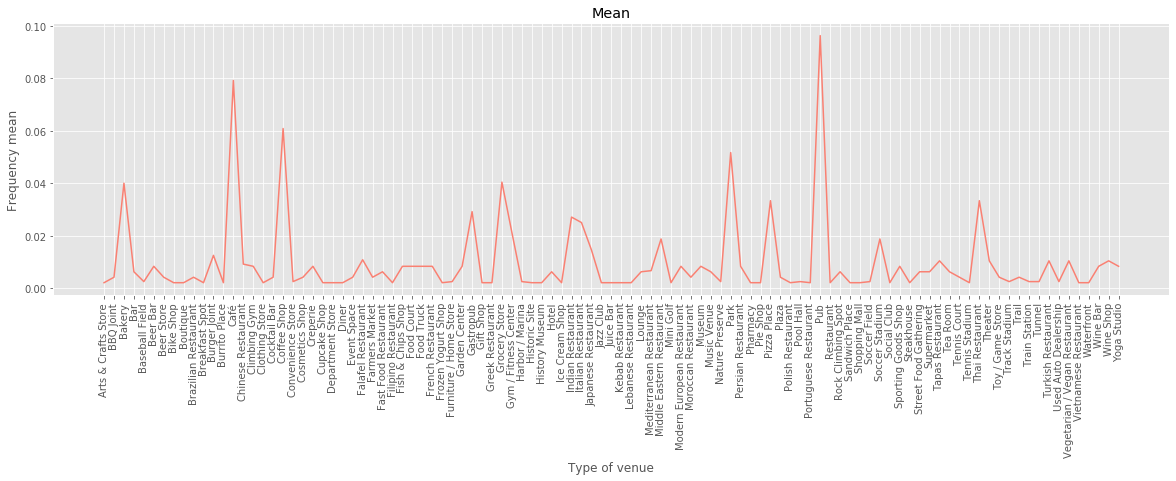

In [26]:
snsline(venues_freq.mean().reset_index(),'Frequency mean', 'Mean', color = 'salmon')

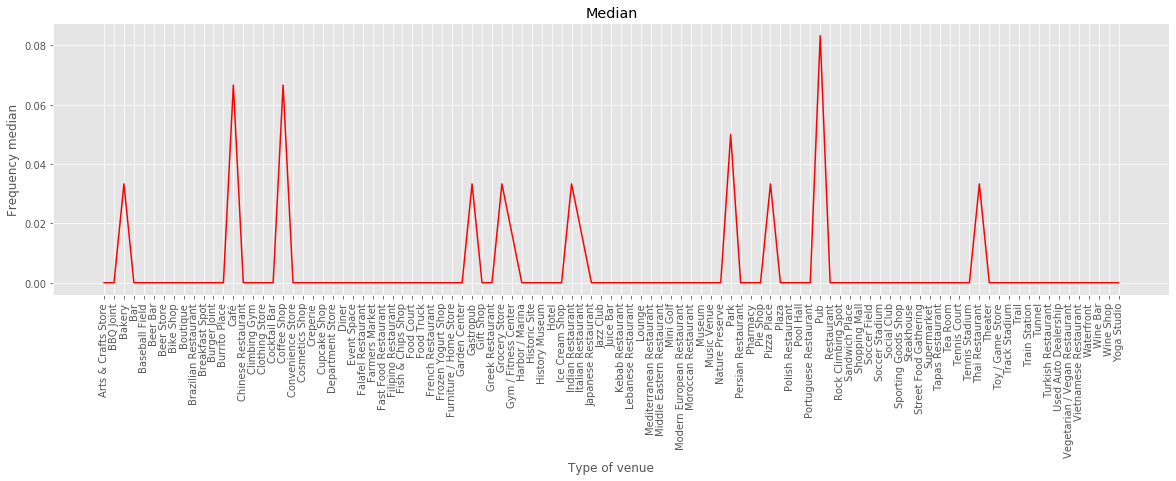

In [27]:
snsline(venues_freq.median().reset_index(),'Frequency median', 'Median', color = 'red')

It can be noted that the most common venues are pub, cafe and coffee shop. They have the highest median and mean frequencies. Standard deviation for most venues is quite low, therefore the venues df can be considered as homogeneous.

Common venues where median is above zero are bakery, gastropub, grocery store, Indian restaurant, pizza place, Thai Restaurant and Parks.

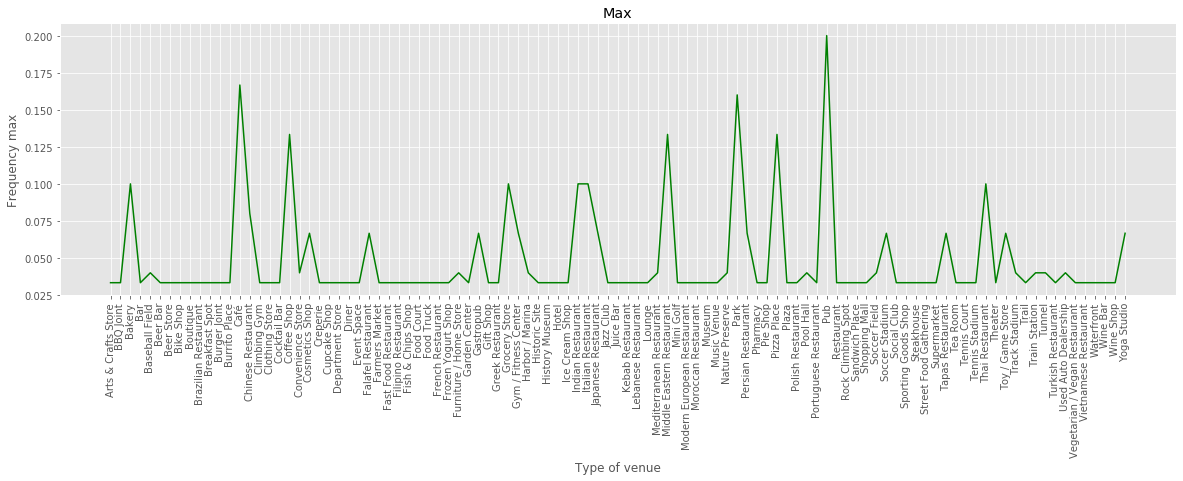

In [28]:
max_freq = venues_freq.max().iloc[1:].reset_index()
max_freq[0] = max_freq[0].astype(float)
snsline(max_freq,'Frequency max', 'Max', color = 'green')

The max highest frequencies are more or less same as medians. It is worth noting that Middle Eastern and Italian Restaurants have high max frequencies, although the median is 0, some wards enjoying this cuisine more than others.

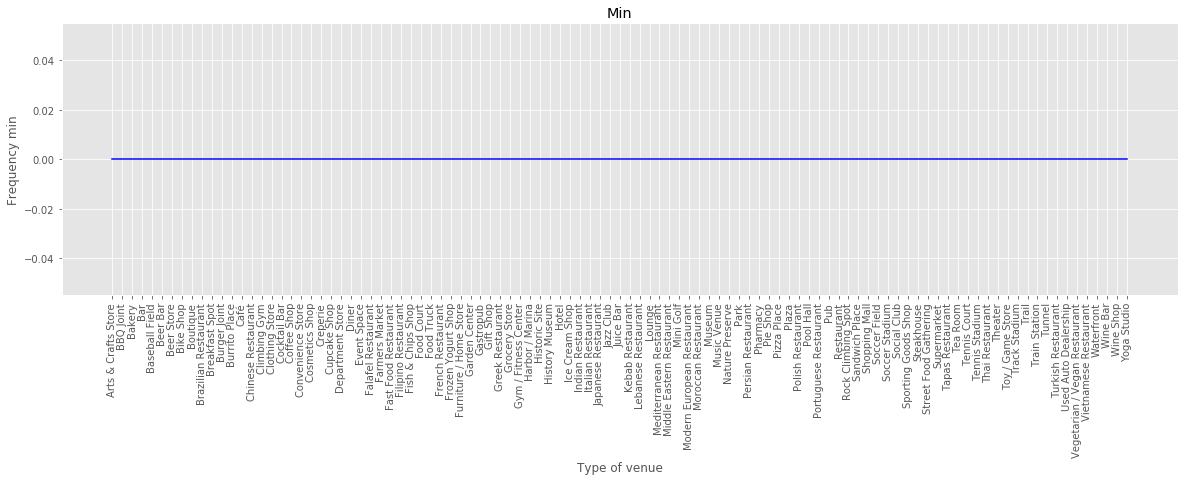

In [29]:
min_freq = venues_freq.min().iloc[1:].reset_index()
min_freq[0] = min_freq[0].astype(float)
snsline(min_freq,'Frequency min', 'Min', color = 'blue')

The minimum frequency for each venue type is zero, which means that there is at least one ward for each venue type that does not have that venue.

In [30]:
#add number of schools
venues_freq = venues_freq.merge(df[['borough','schools']], how = 'left', on = 'borough') 

In [31]:
venues_freq.head()

,borough,Arts & Crafts Store,BBQ Joint,Bakery,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Boutique,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Department Store,Diner,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lebanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Moroccan Restaurant,Museum,Music Venue,Nature Preserve,Park,Persian Restaurant,Pharmacy,Pie Shop,Pizza Place,Plaza,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Restaurant,Rock Climbing Spot,Sandwich Place,Shopping Mall,Soccer Field,Soccer Stadium,Social Club,Sporting Goods Shop,Steakhouse,Street Food Gathering,Supermarket,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Used Auto Dealership,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio,schools
0,Addison,0.0,0.000000,0.100000,0.000000,0.00,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.033333,0.033333,0.0,0.0,0.033333,0.000000,0.00,0.0,0.033333,0.000000,0.0,0.0,0.000000,0.066667,0.033333,0.033333,0.000000,0.0,0.000000,0.033333,0.0,0.0,0.00,0.000000,0.066667,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.033333,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.033333,0.00,0.033333,0.033333,0.0,0.0,0.033333,0.0,0.0,0.00,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.033333,0.0,0.0,0.000000,0.033333,0.0,0.00,0.0,0.00,0.00,0.033333,0.00,0.0,0.0,0.0,0.033333,0.000000,0.0,2
1,Askew,0.0,0.000000,0.066667,0.033333,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.033333,0.00,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.033333,0.066667,0.000000,0.0,0.066667,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.100000,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.100000,0.0,0.000000,0.033333,0.000000,0.000000,0.00,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.066667,0.000000,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,5
2,Avonmore and Brook Green,0.0,0.000000,0.066667,0.033333,0.00,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.000000,0.066667,0.00,0.0,0.000000,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.033333,0.0,0.033333,0.033333,0.00,0.0,0.033333,0.033333,0.0,0.033333,0.100000,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.033333,0.0,0.033333,0.000000,0.033333,0.000000,0.00,0.000000,0.066667,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.033333,0.033333,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,9
3,College Park and Old Oak,0.0,0.000000,0.040000,0.000000,0.04,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.080000,0.0,0.0,0.000000,0.040000,0.04,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.040000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.04,0.000000,0.000000,0.000000,0.0,0.080000,0.040000,0.04,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.

## Segment wards using KMeans

First let's identify what is the optimal number of clusters by building dendorgamm and calculating siloutte score for various options.

In [32]:
#Стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(venues_freq.drop('borough', axis = 1))

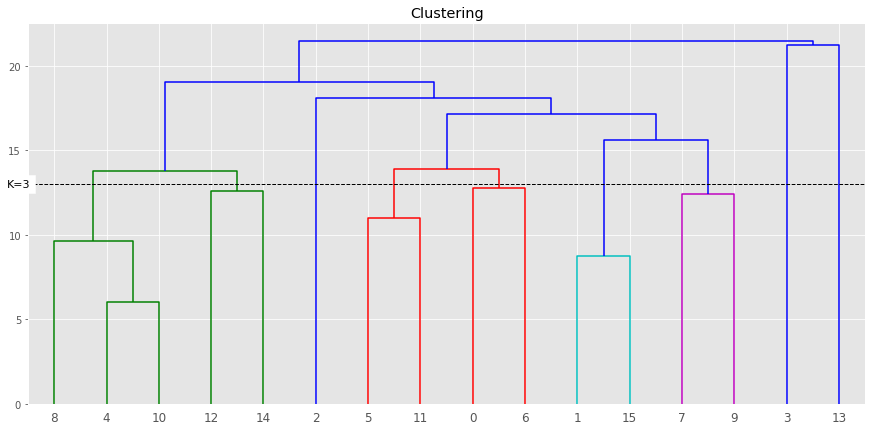

In [33]:
#Distance matrix 
linked = linkage(x_sc, method = 'ward')

#dendrogram vizualization
plt.figure(figsize = (15,7))
dendrogram(linked, orientation = 'top')
plt.axhline(y=13, c='black', lw=1, linestyle='dashed')
plt.text(0.5, 13, 'K=3', fontsize=11, va='center', ha='right', backgroundcolor='w')
plt.title('Clustering')
plt.show()

In [34]:
for i in range(2,7):
    km_0 = KMeans(n_clusters = i, random_state = 0)
    labels_2 = km_0.fit_predict(x_sc)
    s_score = round(silhouette_score(x_sc, labels_2),3)
    print(f'If number of classes is {i}, then silhouette score is {s_score:.3f}')

If number of classes is 2, then silhouette score is 0.221
If number of classes is 3, then silhouette score is 0.055
If number of classes is 4, then silhouette score is 0.066
If number of classes is 5, then silhouette score is 0.089
If number of classes is 6, then silhouette score is 0.057


We can see how dendrogramm allocated each borough to particular group, identifying 5 different colors / groups.

However silhouette score shows that the best number of clusters will be only two, where score is 0.221. 
For 5 clusters silhouette score is higher than for the rest.

In [35]:
# set number of clusters 5
kclusters = 5
km = KMeans(n_clusters = kclusters, random_state = 0)
# run k-means clustering
labels = km.fit_predict(x_sc)

In [36]:
# add clustering labels
venues_freq['label'] = labels
venues_freq.head()

,borough,Arts & Crafts Store,BBQ Joint,Bakery,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Boutique,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Department Store,Diner,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gastropub,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lebanese Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Moroccan Restaurant,Museum,Music Venue,Nature Preserve,Park,Persian Restaurant,Pharmacy,Pie Shop,Pizza Place,Plaza,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Restaurant,Rock Climbing Spot,Sandwich Place,Shopping Mall,Soccer Field,Soccer Stadium,Social Club,Sporting Goods Shop,Steakhouse,Street Food Gathering,Supermarket,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Used Auto Dealership,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio,schools,label
0,Addison,0.0,0.000000,0.100000,0.000000,0.00,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.033333,0.033333,0.0,0.0,0.033333,0.000000,0.00,0.0,0.033333,0.000000,0.0,0.0,0.000000,0.066667,0.033333,0.033333,0.000000,0.0,0.000000,0.033333,0.0,0.0,0.00,0.000000,0.066667,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.033333,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.033333,0.00,0.033333,0.033333,0.0,0.0,0.033333,0.0,0.0,0.00,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.033333,0.033333,0.0,0.0,0.000000,0.033333,0.0,0.00,0.0,0.00,0.00,0.033333,0.00,0.0,0.0,0.0,0.033333,0.000000,0.0,2,4
1,Askew,0.0,0.000000,0.066667,0.033333,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.033333,0.00,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.033333,0.066667,0.000000,0.0,0.066667,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.100000,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.100000,0.0,0.000000,0.033333,0.000000,0.000000,0.00,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.066667,0.000000,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,5,1
2,Avonmore and Brook Green,0.0,0.000000,0.066667,0.033333,0.00,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.000000,0.066667,0.00,0.0,0.000000,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.033333,0.0,0.033333,0.033333,0.00,0.0,0.033333,0.033333,0.0,0.033333,0.100000,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.033333,0.0,0.033333,0.000000,0.033333,0.000000,0.00,0.000000,0.066667,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.033333,0.033333,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,9,1
3,College Park and Old Oak,0.0,0.000000,0.040000,0.000000,0.04,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.080000,0.0,0.0,0.000000,0.040000,0.04,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.040000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.04,0.000000,0.000000,0.000000,0.0,0.080000,0.040000,0.04,0.0,0.000000,0.000000,0.0,0.000000

In [37]:
# add to most common venues df cluster labels
venues_final = venues_final.merge(venues_freq[['borough','label']], how = 'left', on = 'borough')

# add to most common venues df coordinates of the boroughs
venues_final = venues_final.merge(df[['borough','lon','lat']], how = 'left', on = 'borough')

In [38]:
venues_final.sort_values(by = 'label')

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools,label,lon,lat
4,Fulham Broadway,Pub,Pizza Place,Coffee Shop,Café,Gastropub,4,0,-0.194349,51.4809
8,North End,Pizza Place,Pub,Soccer Stadium,Café,Bakery,3,0,-0.199524,51.4814
10,Parsons Green and Walham,Pub,Café,Park,Gym / Fitness Center,Soccer Stadium,4,0,-0.191032,51.4772
12,Sands End,Park,Café,Pub,Bakery,Coffee Shop,5,0,-0.187112,51.4725
14,Town,Café,Coffee Shop,Yoga Studio,Grocery Store,Park,4,0,-0.201784,51.4764
1,Askew,Pub,Middle Eastern Restaurant,Indian Restaurant,Grocery Store,Park,5,1,-0.241357,51.5028
2,Avonmore and Brook Green,Italian Restaurant,Café,Bakery,Persian Restaurant,Coffee Shop,9,1,-0.206258,51.4945
7,Munster,Café,Pizza Place,Thai Restaurant,Italian Restaurant,Pub,4,1,-0.213286,51.4818
9,Palace Riverside,Coffee Shop,Café,Park,Pub,Yoga Studio,5,1,-0.215168,51.4705
15,Wormholt and White City,Middle Eastern Restaurant,Grocery Store,Indian Restaurant,Pub,Café,8,1,-0.240642,51.5088


In [47]:
# create map
map_clusters = folium.Map(location=[51.4941207,-0.2400271], zoom_start=12.5, tiles = 'cartodb positron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_final['lat'], venues_final['lon'], 
                                  venues_final['borough'], venues_final['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Clusters description 

---

## Cluster 0 - red

---


Most common venues for cluster 0 are pubs. Unlike cluster 1, other common venues are not only places to eat, but gyms, stadiums, yoga etc.

In [48]:
venues_final[venues_final['label'] == 0]

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools,label,lon,lat
4,Fulham Broadway,Pub,Pizza Place,Coffee Shop,Café,Gastropub,4,0,-0.194349,51.4809
8,North End,Pizza Place,Pub,Soccer Stadium,Café,Bakery,3,0,-0.199524,51.4814
10,Parsons Green and Walham,Pub,Café,Park,Gym / Fitness Center,Soccer Stadium,4,0,-0.191032,51.4772
12,Sands End,Park,Café,Pub,Bakery,Coffee Shop,5,0,-0.187112,51.4725
14,Town,Café,Coffee Shop,Yoga Studio,Grocery Store,Park,4,0,-0.201784,51.4764


## Cluster 1 - purple

---

Cluster 1 is the most scattered on the map. It has largest number of schools. Most common venues are mainly places to eat. 


In [50]:
venues_final[venues_final['label'] == 1]

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools,label,lon,lat
1,Askew,Pub,Middle Eastern Restaurant,Indian Restaurant,Grocery Store,Park,5,1,-0.241357,51.5028
2,Avonmore and Brook Green,Italian Restaurant,Café,Bakery,Persian Restaurant,Coffee Shop,9,1,-0.206258,51.4945
7,Munster,Café,Pizza Place,Thai Restaurant,Italian Restaurant,Pub,4,1,-0.213286,51.4818
9,Palace Riverside,Coffee Shop,Café,Park,Pub,Yoga Studio,5,1,-0.215168,51.4705
15,Wormholt and White City,Middle Eastern Restaurant,Grocery Store,Indian Restaurant,Pub,Café,8,1,-0.240642,51.5088


## Cluster 2 - blue

---

Cluster 2 include only one area - Shepher's Bush. Comparing to other clusters it has three venues out of five which are not place to eat, also it does not have pubs / coffee shops / cafes / parks amongst the most common. 

In [51]:
venues_final[venues_final['label'] == 2]

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools,label,lon,lat
13,Shepherd's Bush Green,Falafel Restaurant,Bakery,Cosmetics Shop,Toy / Game Store,Ice Cream Shop,4,2,-0.221755,51.5042


## Cluster 3 - green

---

Only one area was allocated to the cluster 3. Cluster three is quite different from others as 5 most common venues include only one place to eat, rest are stores, parks, fields. And looking at the map it can be seen that this area is further away from others and has large green area.

In [52]:
venues_final[venues_final['label'] == 3]

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools,label,lon,lat
3,College Park and Old Oak,Park,Grocery Store,Chinese Restaurant,Furniture / Home Store,Soccer Field,5,3,-0.242518,51.5183


## Cluster 4 - orange

---

This cluster includes areas with relatively large number of schools. Pubs are the most common venues around the area but quite low frequency of coffee shops and cafes comparing to cluster 0, which is similar to cluster 4. For example, in Ravenscourt park 5 most common venues do not include coffee shops or cafes. And parks are common venues only in one ward, Ravenscourt park.

In [53]:
venues_final[venues_final['label'] == 4]

,borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,schools,label,lon,lat
0,Addison,Bakery,Pub,Falafel Restaurant,Gastropub,Italian Restaurant,2,4,-0.218356,51.499
5,Fulham Reach,Pub,Coffee Shop,Café,Thai Restaurant,Creperie,12,4,-0.226158,51.4872
6,Hammersmith Broadway,Pub,Tapas Restaurant,Coffee Shop,Café,Burger Joint,10,4,-0.224162,51.4922
11,Ravenscourt Park,Pub,Park,Thai Restaurant,Indian Restaurant,Japanese Restaurant,6,4,-0.235793,51.4941


# Summary

---
**Results**

In this project we have analyzed foursquare data on venues and government data on number of schools for wards located in Hammersmith and Fulham council in London. 

Using KMeans algorithm we have segmented wards into five clusters. 

---
**Discussion**

Foursquare data isn’t all-encompassing. The highest number of venues are in the Food categories. Data doesn’t take into account a venue’s size, it can duplicate venues due to radius limitations described earlier in the analysis. Also the data largely rely on categorization of the users, same type of venues can be classified as cafe or coffee shops.

Analysis can be further improved by testing hypothesis if clusters are truly different, if there are statistically significant differences between them.

---

**Conclusion**

Foursquare data is limited but can provide some insights. I suggest it cannot be used alone but maybe as addition to other sources for the purposes of accuracy, completeness and reliability.